# Federated Learning - Régression logistique 2D

### Ce fichier a pour but d'aider la visualisation du fonctionnement et des performances du Federated Learning via le Federated Averaging dans un contexte de régression logistique 2D avec 2 classes. Le but de notre modèle est donc de données une bonne prédiction quant à la probabilité d'appartenir à la classe 1.

In [1]:
# Importation des modules de génération de données
from FLSimulator import OneDimensionalRDG, OneDimensionalLRDG, TwoClusterGenerator

# Importation des modèles de machine learning disponibles
from FLSimulator import GDRegressor, LogisticRegressor

# Importation des modules pour créer un réseau fédéré
from FLSimulator import CentralServer, Node, FederatedNetwork

# Importation d'un module a utilisé comme fonction de base phi
from FLSimulator import polynomial_features

# Importation d'une fonction pour regrouper les données de façon centralisé
from FLSimulator import regroup_data_base

# Importation d'autres modules
from random import randint, choice
from scipy.stats import multivariate_normal, norm
from matplotlib import pyplot as plt
import numpy as np

# Mise en place de variable global pour uniformiser des tests
E = 1 # Local Epochs done in each round of training
C = 1   # Minibatch size during in each round of training
agg = 'FedAvg' # Aggregation method
n_s = 'all' # Node selection
rand_size = 0.80 # Not used if n_s = 'all'
n_rounds = 10 # Number of rounds during distributed training

### Créons un réseau fédéré simple constitué de 10 bases de données fédérées disposant de 150 à 250 observations partagées inégalement entre 2 classes dont les points seront tirés de distributions gaussiennes multivariées. Le positionnement des moyennes des distributions des classes ainsi que les matrices de covariances changeront légèrement entre chaque base de données fédérées pour éviter d'avoir des distributions de classes iid, soit obtenir une situation plus réaliste.

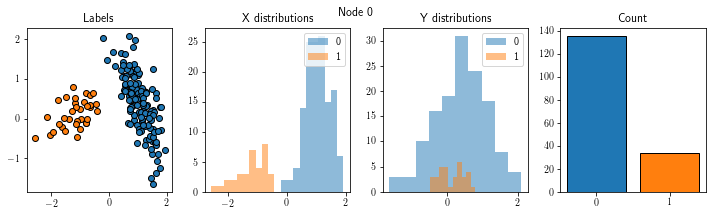

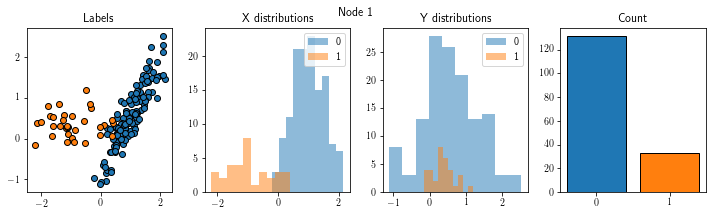

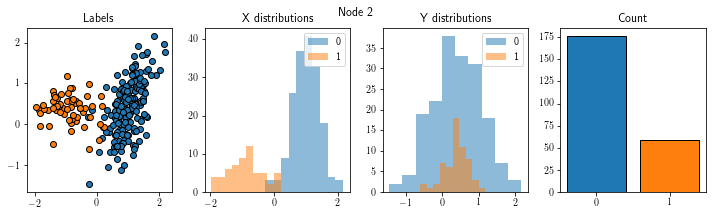

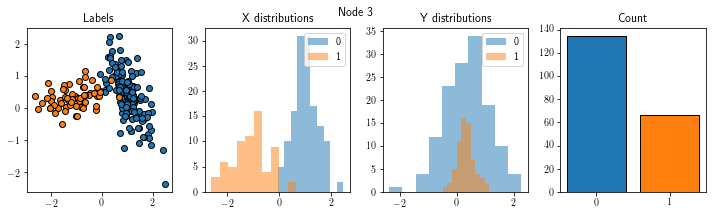

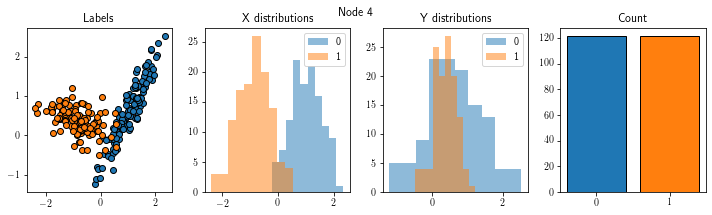

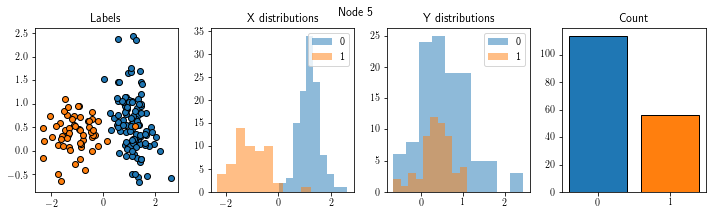

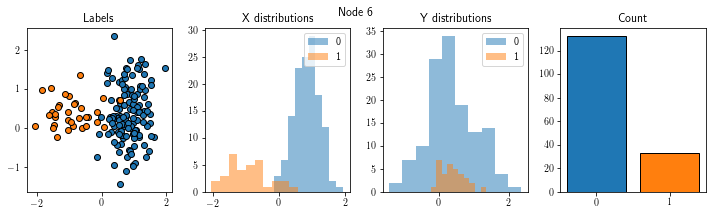

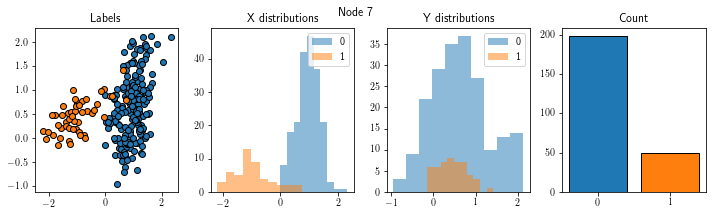

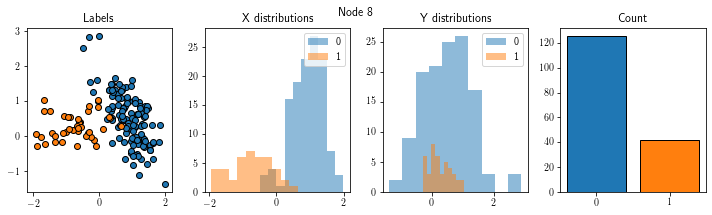

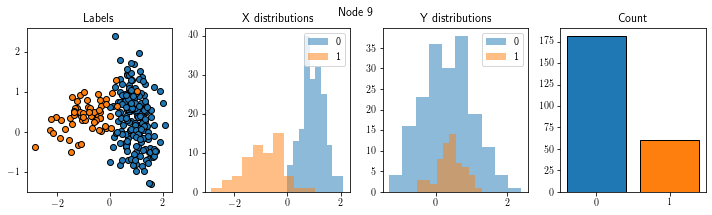

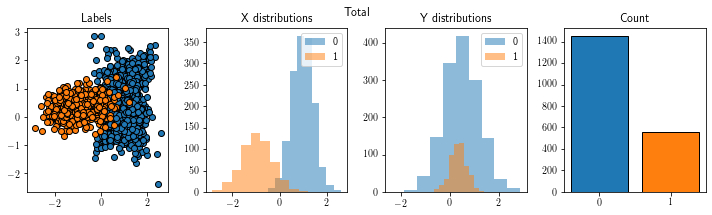

In [2]:
# Activation de LaTeX pour les illustrations
plt.rc('text', usetex=True)

# Création des Node
nodes = []
anti_diagonal = np.array([[0, 1], [1, 0]])
class_proportion = [0.20, 0.20, 0.20, 0.25, 0.25, 0.33, 0.50]
for i in range(10):
    
    # We sample both cluster distribution mean from multivariate guaussians
    mu0 = multivariate_normal.rvs([0.95, 0.50], [0.015, 0.015])
    mu1 = multivariate_normal.rvs([-0.95, 0.35], [0.015, 0.015])
    
    # We select a random sample size between 150 and 250 for both clusters
    n = randint(150, 250)
    prop = choice(class_proportion)
    n0, n1 = int((1-prop)*n), int(prop*n)
    
    # We build covariance matrix for both clusters distribution
    cov0 = np.array([[0.40, 0], [0, 0.7]])
    cov1 = np.array([[0.65, 0], [0, 0.34]])
    
    # We add noises to term (0,1) and (1,0) of both covariance matrix
    lambda0 = norm.rvs(loc=0, scale=0.225)
    lambda1 = norm.rvs(loc=0, scale=0.08)
    cov0 += lambda0*anti_diagonal
    cov1 += lambda1*anti_diagonal
    
    # We multiply both covariance matrix by their tranpose to make sure they are positive semi-definite
    cov0 = np.matmul(cov0, cov0.T)
    cov1 = np.matmul(cov1, cov1.T)
    
    # We generate nodes
    X, t = TwoClusterGenerator.generate_data(sample_sizes=[n0, n1], centers=[mu0, mu1], covs=[cov0, cov1])
    TwoClusterGenerator.distribution_and_labels(X, t, title='Node ' + str(i))
    nodes.append(Node(X, t))
    
# Illustration de la base de données si elle était centralisée
X_total, t_total = regroup_data_base(nodes)
TwoClusterGenerator.distribution_and_labels(X_total, t_total, title='Total')







In [3]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degré 1
logistic_reg = LogisticRegressor(phi=polynomial_features(1), eta0=1, learning_rate='invscaling')

# Création du server central
c_server = CentralServer(global_model=logistic_reg, aggregation=agg, node_selection=n_s, C=C, E=E, random_size=rand_size)

# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

### On effectue maintenant 10 "rounds" d'entraînements et visualisons les performances du modèle global à jour entre chaque "round" en regroupant l'ensemble des bases de données dans une figure commune. Notons ici que loss = $\sum_{k=1}^{10} E(w^{t})$  où $E$ est la _cross entropy_ et $t$ ici vaut 10 .

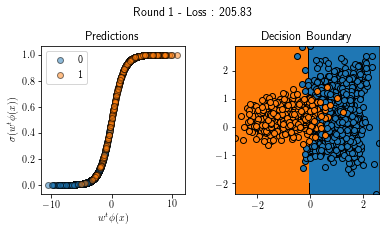

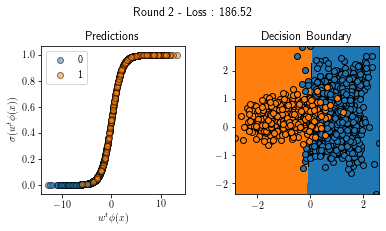

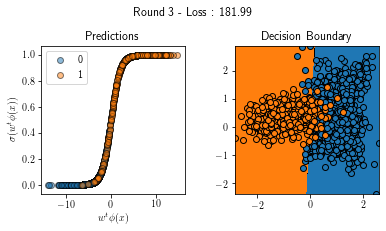

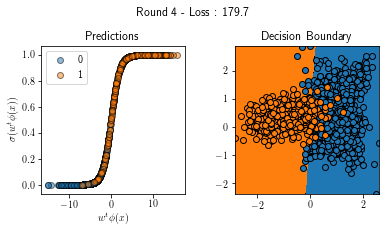

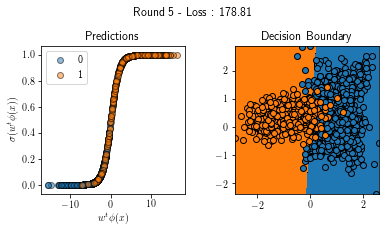

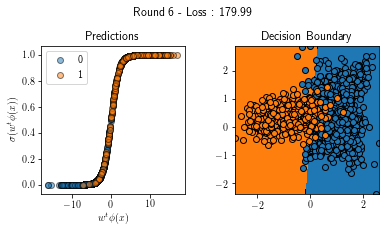

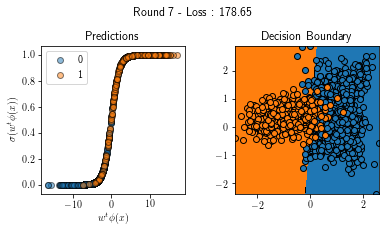

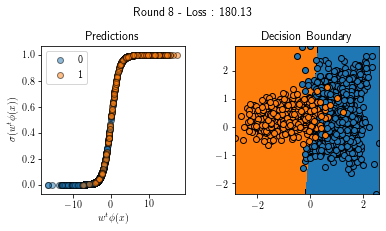

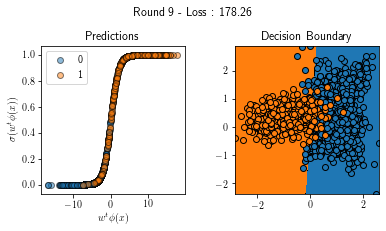

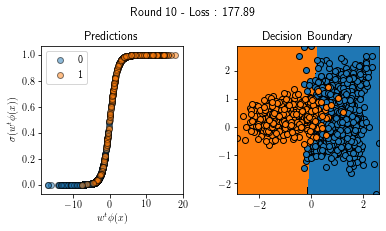

In [4]:
loss_progress = f_network.run_learning(nb_of_rounds=n_rounds, show_round_results=True, loss_progress=True)

### On effectue maintenant 10 "rounds" d'entraînements avec le même réseau si la fonction de base du modèle de régression logistic avait été de degré 2

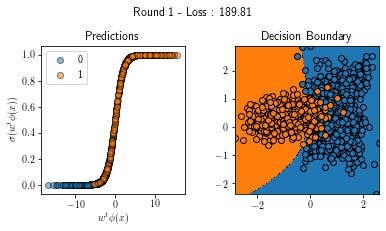

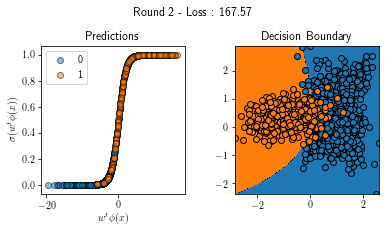

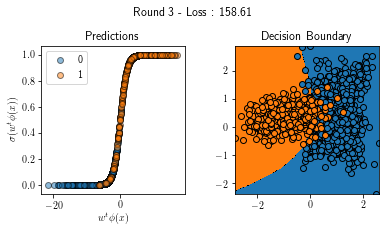

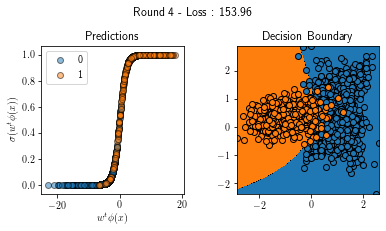

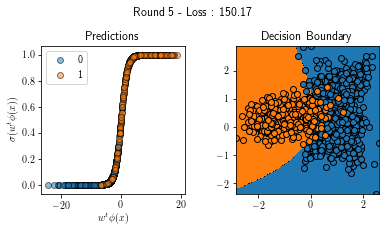

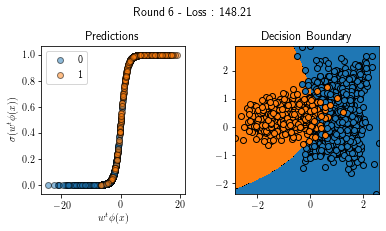

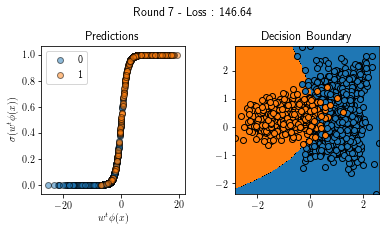

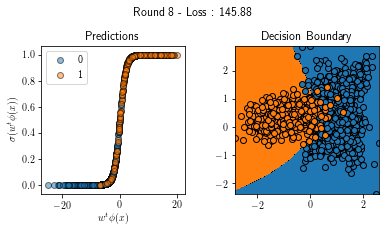

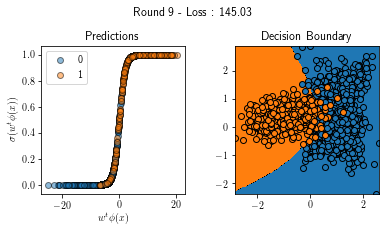

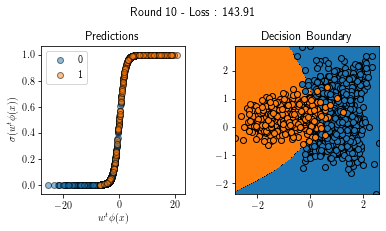

In [5]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degrés 2
logistic_reg2 = LogisticRegressor(phi=polynomial_features(2), eta0=1, learning_rate='invscaling')

# Création du server central
c_server = CentralServer(global_model=logistic_reg2, aggregation=agg, node_selection=n_s, C=C, E=E, random_size=rand_size)

# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

# Entraînement du réseau
loss_progress2 = f_network.run_learning(nb_of_rounds=n_rounds, show_round_results=True, loss_progress=True)

### On effectue maintenant 10 "rounds" d'entraînements avec le même réseau si la fonction de base du modèle de régression logistic avait été de degré 3

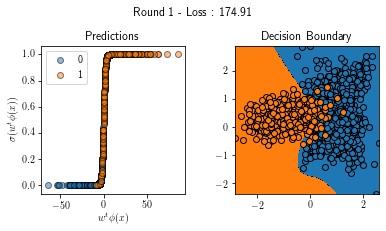

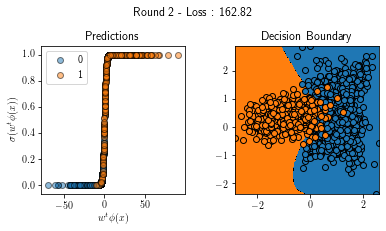

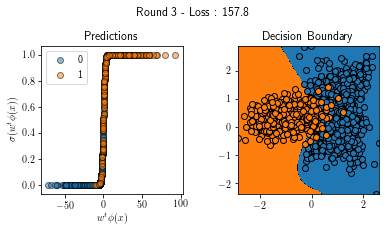

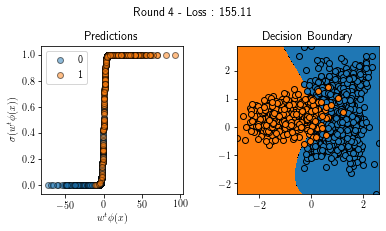

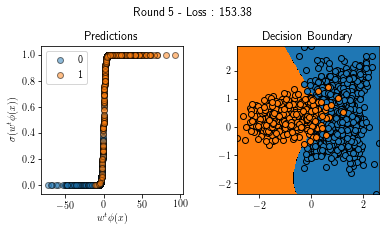

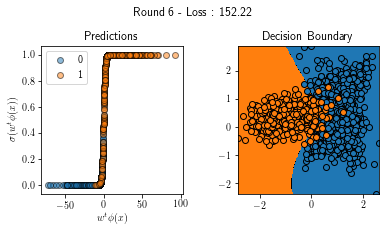

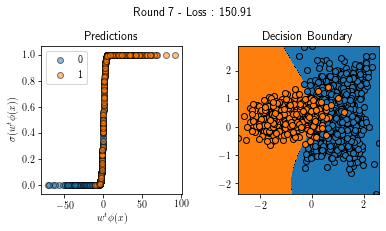

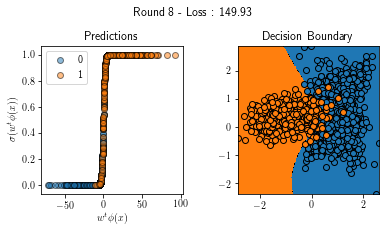

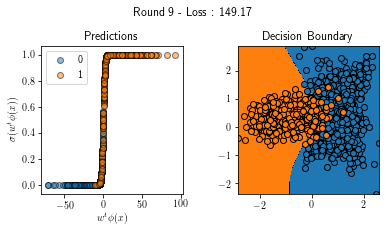

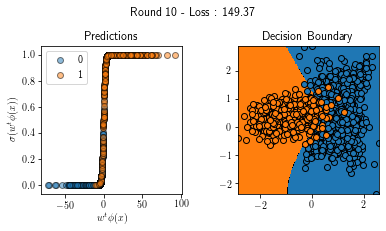

In [6]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degrés 3
logistic_reg3 = LogisticRegressor(phi=polynomial_features(3), eta0=1, learning_rate='invscaling')

# Création du server central
c_server = CentralServer(global_model=logistic_reg3, aggregation=agg, node_selection=n_s, C=C, E=E, random_size=rand_size)

# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

# Entraînement du réseau
loss_progress3 = f_network.run_learning(nb_of_rounds=n_rounds, show_round_results=True, loss_progress=True)

### On effectue maintenant 10 "rounds" d'entraînements avec le même réseau si la fonction de base du modèle de régression logistic avait été de degré 4

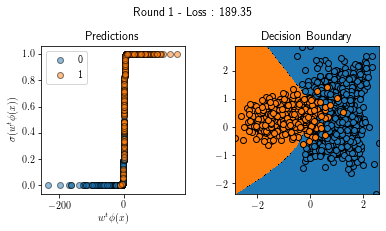

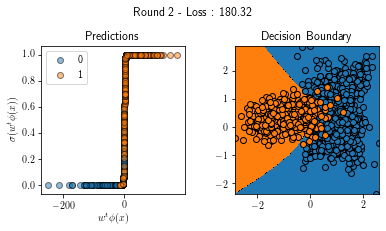

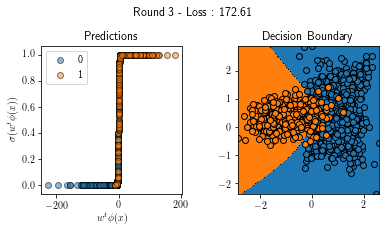

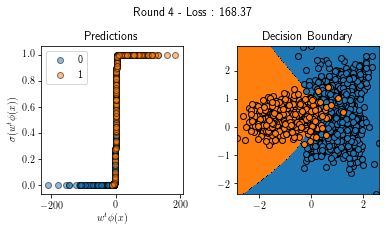

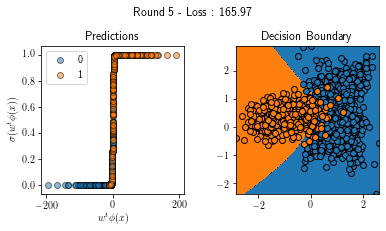

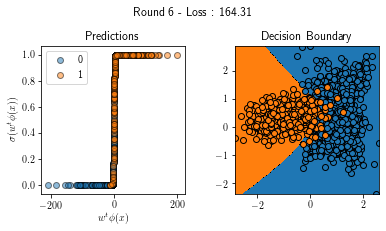

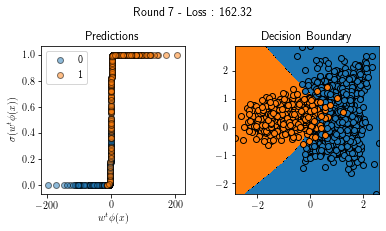

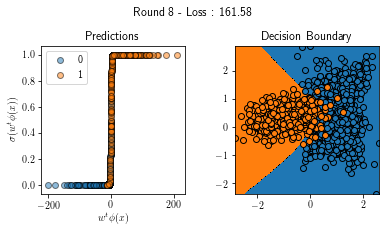

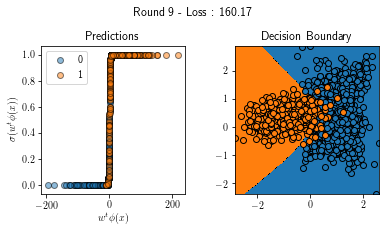

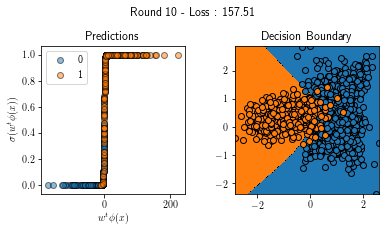

In [7]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degrés 3
logistic_reg4 = LogisticRegressor(phi=polynomial_features(4), eta0=1, learning_rate='invscaling')

# Création du server central
c_server = CentralServer(global_model=logistic_reg4, aggregation=agg, node_selection=n_s, C=C, E=E, random_size=rand_size)

# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

# Entraînement du réseau
loss_progress4 = f_network.run_learning(nb_of_rounds=n_rounds, show_round_results=True, loss_progress=True)

### Poursuivons en entraînant de façon centralisé, un modèle semblable à celui qui a eu la meilleure performance au niveau distribué.

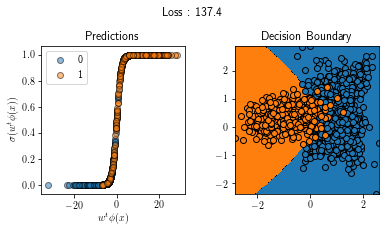

In [8]:
# Création d'un nouveau modèle de régression logistic semblable au modèle global précédent
local_logistic_reg = LogisticRegressor(phi=polynomial_features(2), eta0=1, learning_rate='invscaling')

# Entrainons le localement avec l'ensemble des données et un budget total d'epochs considérable
local_logistic_reg.train(X_total, t_total, minibatch_size=C, nb_epoch=(E*n_rounds))

# Comparons le modèle local au modèle fédéré
centralized_loss = round(local_logistic_reg.loss(X_total, t_total), 2)
local_logistic_reg.plot_model(X_total, t_total, title='Loss : ' + str(centralized_loss))

### Finalement comparons la progression des loss au fil des rounds pour les différents modèles

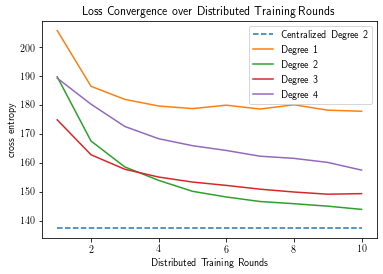

In [9]:
round_range = list(range(1, 11))
plt.plot(round_range, [centralized_loss]*len(round_range), '--', label='Centralized Degree 2')
plt.plot(round_range, loss_progress, '-', label='Degree 1')
plt.plot(round_range, loss_progress2, '-', label='Degree 2')
plt.plot(round_range, loss_progress3, '-', label='Degree 3')
plt.plot(round_range, loss_progress4, '-', label='Degree 4')
plt.legend(loc='upper right')
plt.title('Loss Convergence over Distributed Training Rounds')
plt.xlabel('Distributed Training Rounds')
plt.ylabel('cross entropy')
plt.show()
